In [93]:
import numpy as np
import h5py
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation, BatchNormalization
import tensorflow as tf
from tensorflow.keras.optimizers import Adam  # optimizer hyperparameter
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
from sklearn.model_selection import train_test_split
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [94]:
#labels for binary classification: 0: AD, 1: EMCI, 2: LMCI, 3:NC
mapping = {
    0: 'AD',
    1: 'EMCI',
    2: 'LMCI',
    3: 'NC'
}

labels = [2, 0]

In [95]:
def loadAlzeimer(plane):
    if plane == 'coronal':
        print(plane)
        with h5py.File('data/Coronal-Augmented.h5', 'r') as hdf:
            G1 = hdf.get('Train Data')
            trainX = np.array(G1.get('x_train'))
            trainY = np.array(G1.get('y_train'))
            G2 = hdf.get('Test Data')
            testX = np.array(G2.get('x_test'))
            testY = np.array(G2.get('y_test'))

    elif plane == 'sagittal':
        print(plane)
        with h5py.File('data/Sagittal-Augmented.h5', 'r') as hdf:
            G1 = hdf.get('Train Data')
            trainX = np.array(G1.get('x_train'))
            trainY = np.array(G1.get('y_train'))
            G2 = hdf.get('Test Data')
            testX = np.array(G2.get('x_test'))
            testY = np.array(G2.get('y_test'))
    
    else:
        print(plane)
        with h5py.File('data/Axial-Augmented.h5', 'r') as hdf:
            G1 = hdf.get('Train Data')
            trainX = np.array(G1.get('x_train'))
            trainY = np.array(G1.get('y_train'))
            G2 = hdf.get('Test Data')
            testX = np.array(G2.get('x_test'))
            testY = np.array(G2.get('y_test'))
    
    return trainX, trainY, testX, testY


In [96]:
planeName ='sagittal'
modelName ='CNNScratch'
x_train, y_train, x_test, y_test = loadAlzeimer(planeName)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


sagittal
(9699, 218, 182, 1) (9699,) (4157, 218, 182, 1) (4157,)


In [97]:
#extract first class labels out of binary classes 
def extract_binary_classes(X, Y, classes):
    label1 = classes[0]
    label2 = classes[1]

    idx1 = [np.where(Y == label1)[0]]
    idx1 = np.array(idx1)
    idx1 = idx1.T
    idx1 = np.squeeze(idx1)
    xtrain_class1 = X[idx1]
    ytrain_class1 = Y[idx1]
    # print('label 1 shape')
    # print(xtrain_class1.shape)
    # print(ytrain_class1.shape)

    idx2 = [np.where(Y == label2)[0]]
    idx2 = np.array(idx2)
    idx2 = idx2.T
    idx2 = np.squeeze(idx2)
    xtrain_class2 = X[idx2]
    ytrain_class2 = Y[idx2]

    # print('label 2 shape')
    # print(xtrain_class2.shape)
    # print(ytrain_class2.shape)
    X_new = np.concatenate((xtrain_class1, xtrain_class2), axis=0)
    Y_new = np.concatenate((ytrain_class1, ytrain_class2), axis=0)
    X_new,_,Y_new,_ = train_test_split(X_new, Y_new, test_size=0.001, random_state=42)
    # print('final shape')
    # print(X_new.shape)
    # print(Y_new.shape)
    
    return X_new, Y_new



In [98]:

x_train, y_train = extract_binary_classes(x_train,y_train, labels)
x_test, y_test = extract_binary_classes(x_test,y_test, labels)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(5379, 218, 182, 1) (5379,) (2318, 218, 182, 1) (2318,)


In [99]:
#Run this code only for CNN Scratch
from tensorflow.keras.utils import to_categorical
#x_train = np.expand_dims(x_train, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
print(y_train.shape)
y_train_cat = to_categorical(y_train, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)
print('X train shape', x_train.shape)
print('Y train shape', y_train_cat.shape)
row = x_train.shape[1]
col = x_train.shape[2]
print(row, col)

(5379,)
X train shape (5379, 218, 182, 1)
Y train shape (5379, 4)
218 182


In [100]:
#code for CNN Scratch model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape=(row,col,1), activation='relu'))
model.add(Conv2D(16, (3, 3), activation='relu'))

#model.add(Conv2D(16, (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(16, (1,1)))

model.add(Flatten())

model.add(Dense(4, activation = 'softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics =['acc'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 216, 180, 16)      160       
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 214, 178, 16)      2320      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 107, 89, 16)       0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 105, 87, 32)       4640      
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 103, 85, 32)       9248      
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 101, 83, 32)       9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 50, 41, 32)       

In [101]:
METRIC = tf.keras.metrics.AUC(name='acc')
# learning rate hyperparameter.
model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy', metrics=METRIC)


In [102]:

filepath = 'weights-binary/' + modelName + '_' + planeName + '_' + mapping[labels[0]] + 'vs' + mapping[labels[1]] + '.hdf5'
print(filepath)

earlystopping = EarlyStopping(monitor='acc',
                              mode='max',
                              patience=15,
                              verbose=1)

checkpoint = ModelCheckpoint(filepath,
                             monitor='acc',
                             mode='max',
                             save_best_only=True,
                             verbose=1)
callback_list = [earlystopping, checkpoint]


weights-binary/CNNScratch_sagittal_LMCIvsAD.hdf5


In [103]:
# training
# batch_size hyperparamter.
print(x_train.shape)
print(y_train_cat.shape)
print(x_test.shape)
print(y_test_cat.shape)
history = model.fit(x_train, y_train_cat, batch_size=128, epochs=30,
                           verbose=2, validation_data=(x_test, y_test_cat), callbacks=callback_list)

(5379, 218, 182, 1)
(5379, 4)
(2318, 218, 182, 1)
(2318, 4)
Epoch 1/30
43/43 - 7s - loss: 0.8974 - acc: 0.8716 - val_loss: 0.5860 - val_acc: 0.9217

Epoch 00001: acc improved from -inf to 0.87158, saving model to weights-binary\CNNScratch_sagittal_LMCIvsAD.hdf5
Epoch 2/30
43/43 - 6s - loss: 0.5324 - acc: 0.9375 - val_loss: 0.6727 - val_acc: 0.9249

Epoch 00002: acc improved from 0.87158 to 0.93746, saving model to weights-binary\CNNScratch_sagittal_LMCIvsAD.hdf5
Epoch 3/30
43/43 - 6s - loss: 0.4318 - acc: 0.9605 - val_loss: 0.4365 - val_acc: 0.9607

Epoch 00003: acc improved from 0.93746 to 0.96051, saving model to weights-binary\CNNScratch_sagittal_LMCIvsAD.hdf5
Epoch 4/30
43/43 - 6s - loss: 0.3538 - acc: 0.9743 - val_loss: 0.3914 - val_acc: 0.9689

Epoch 00004: acc improved from 0.96051 to 0.97430, saving model to weights-binary\CNNScratch_sagittal_LMCIvsAD.hdf5
Epoch 5/30
43/43 - 6s - loss: 0.3385 - acc: 0.9764 - val_loss: 0.3221 - val_acc: 0.9789

Epoch 00005: acc improved from 0.9

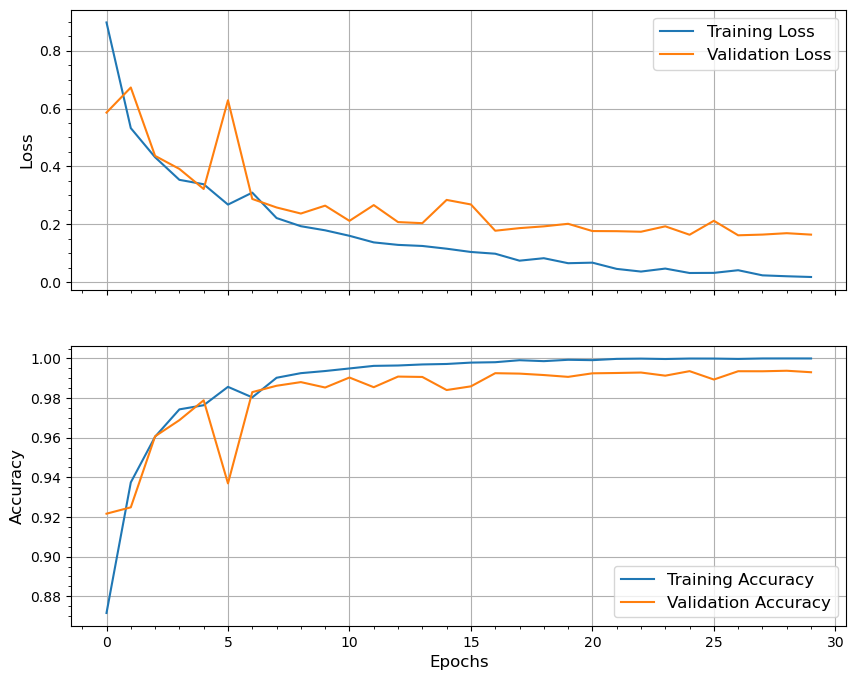

In [104]:
df = pd.DataFrame(history.history)
df.head()
# losses[['acc','val_acc']].plot()
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1,sharex=True, figsize=(10,8))
ax[0].plot(df['loss'],label = 'Training Loss')
ax[0].plot(df['val_loss'],label = 'Validation Loss')
ax[1].plot(df['acc'],label = 'Training Accuracy')
ax[1].plot(df['val_acc'],label = 'Validation Accuracy')
ax[0].legend(loc='best',prop={'size':12})
ax[1].legend(loc='best',prop={'size':12})
ax[0].minorticks_on()
ax[1].minorticks_on()
ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('Accuracy', fontsize=12)
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].grid()
ax[1].grid()
plt.draw()
filepath = 'resultsheets-binary/' + modelName + '_' + planeName + '_' + mapping[labels[0]] + 'vs' + mapping[labels[1]] + '.pdf'

plt.savefig(filepath)

#saving the results
filepath = 'resultsheets-binary/' + modelName + '_' + planeName + '_' + mapping[labels[0]] + 'vs' + mapping[labels[1]] + '.csv'

df.to_csv(filepath)

c:\Users\noush\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.9482909728308502
0.9413763806287171
Accuracy =  0.9447799827437446
   Accuracy  Specificity  Sensitivity       FNR       FPR
0   0.94478     0.948291     0.941376  0.058624  0.051709


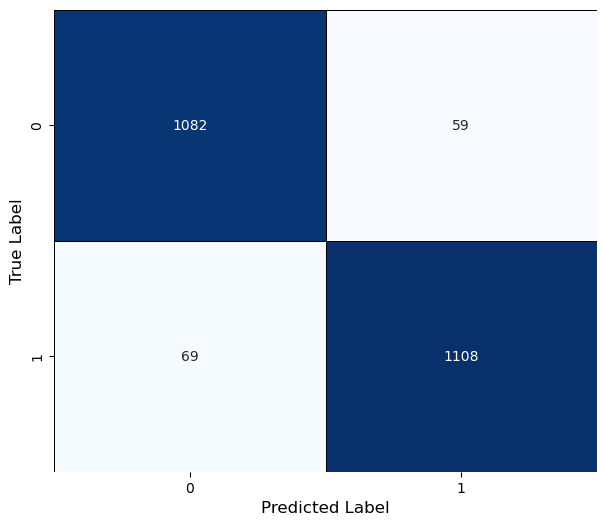

In [105]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#%%
prediction = model.predict_classes(x_test)
cf_matrix = confusion_matrix(y_test, prediction)
fig = plt.figure(figsize=(7, 6))
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False, linewidth=0.5,linecolor="black",fmt='')
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
plt.draw()
filepath = 'cm-binary/' + modelName + '_' + planeName + '_' + mapping[labels[0]] + 'vs' + mapping[labels[1]] + '.pdf'
plt.savefig(filepath)

tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(specificity)
print(sensitivity)

FNR = 1-sensitivity
FPR = 1-specificity

Acc = metrics.accuracy_score(y_test,prediction)
# #auc = metrics.roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print("Accuracy = ", Acc)
# print("AUC =",auc)


metrics = {'Accuracy':[Acc],
           'Specificity':[specificity],
           'Sensitivity':[sensitivity],
           'FNR':[FNR],
           'FPR':[FPR]
          }
df = pd.DataFrame(metrics)
print (df)

filepath = 'metrics-binary/' + modelName + '_' + planeName + '_' + mapping[labels[0]] + 'vs' + mapping[labels[1]] + '.csv'
df.to_csv(filepath)